Kaggle dataset : State Farm distracted driver detection 

In [1]:
import numpy as np
import os 
from glob import glob
import random 
import time 
import tensorflow as tf 
import datetime 

from tqdm import tqdm
import pandas as pd 
from IPython.display import FileLink 
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from tensorflow.python.keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
#On vérifie qu'on utilise bien tensorflow 2.0 : 

assert hasattr(tf, "function") 

In [43]:
dataset = pd.read_csv('Documents/X/PSC/Datasets/distracted_driver/driver_imgs_list.csv')

In [44]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [88]:
# On charge la dataset : 

NUMBER_CLASSES = 10 

def get_cv2_image(path,img_rows,img_cols,color_type=3):
    if color_type == 1 : 
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    
    img = cv2.resize(img , (img_rows , img_cols))
    return img

def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('Documents', 'X', 'PSC', 'Datasets' , 'distracted_driver' , 'imgs' , 'train' , 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('Documents', 'X','PSC', 'Datasets', 'distracted_driver' , 'imgs' , 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [59]:
img_rows = 64
img_cols = 64
color_type = 1

In [60]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:05<00:45,  5.09s/it]

Loading directory c1


 20%|██        | 2/10 [00:10<00:40,  5.12s/it]

Loading directory c2


 30%|███       | 3/10 [00:15<00:35,  5.08s/it]

Loading directory c3


 40%|████      | 4/10 [00:20<00:30,  5.08s/it]

Loading directory c4


 50%|█████     | 5/10 [00:25<00:25,  5.06s/it]

Loading directory c5


 60%|██████    | 6/10 [00:30<00:20,  5.03s/it]

Loading directory c6


 70%|███████   | 7/10 [00:35<00:14,  4.99s/it]

Loading directory c7


 80%|████████  | 8/10 [00:39<00:09,  4.74s/it]

Loading directory c8


 90%|█████████ | 9/10 [00:43<00:04,  4.51s/it]

Loading directory c9


100%|██████████| 10/10 [00:47<00:00,  4.48s/it]

Data Loaded in 47.75919580459595 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [108]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

for file in test_files:
    file = file.astype(np.float32)
    


  0%|          | 165/79726 [00:00<02:26, 543.68it/s]


In [62]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

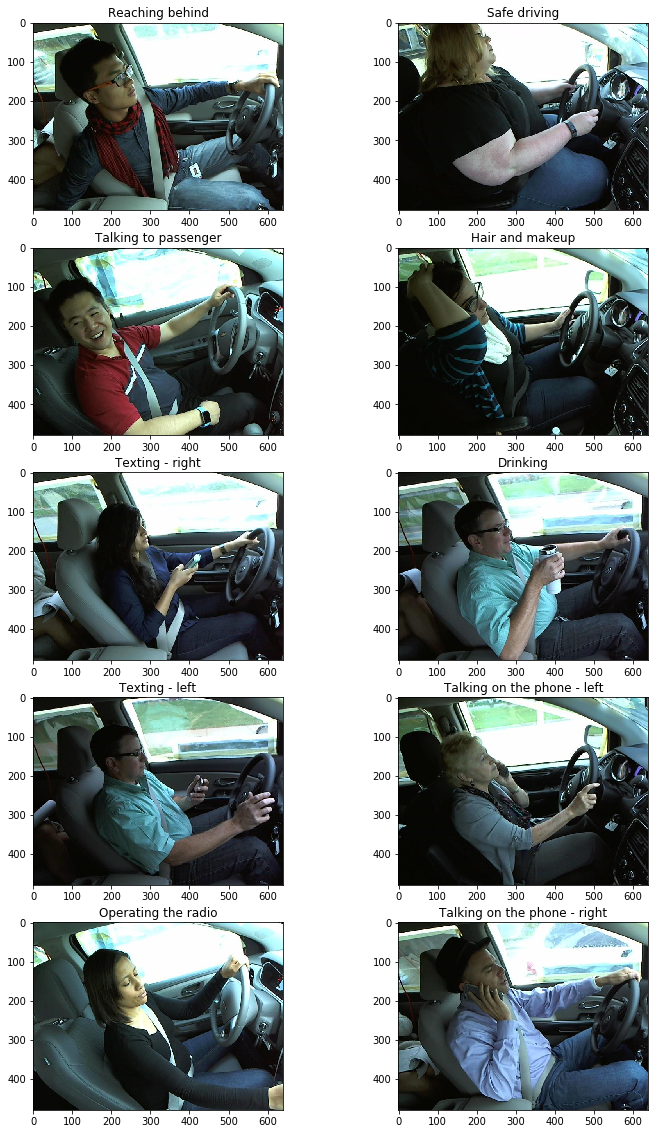

In [63]:
#Visualisation de la dataset : 

plt.figure(figsize = (12,20))
image_count = 1
BASE_URL = 'Documents/X/PSC/Datasets/distracted_driver/imgs/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1 :
                break
            else : 
                fig = plt.subplot(5,2,image_count)
                image_count+=1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])
        

In [64]:
def create_submissions(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

In [65]:
batch_size = 40
nb_epoch = 10

In [66]:
def create_model_v1():
    
    model = Sequential()
    
    model.add(Conv2D(filters = 64, padding = 'same', kernel_size = 3, activation = 'relu', input_shape = (img_rows, img_cols,color_type)))
    model.add(MaxPooling2D(pool_size = 2))
    
    model.add(Conv2D(filters = 128, padding = 'same', kernel_size = 3, activation = 'relu', input_shape = (img_rows, img_cols,color_type)))
    model.add(MaxPooling2D(pool_size = 2))
    
    model.add(Conv2D(filters = 256, padding = 'same', kernel_size = 3, activation = 'relu', input_shape = (img_rows, img_cols,color_type)))
    model.add(MaxPooling2D(pool_size = 2))
    
    model.add(Conv2D(filters = 512, padding = 'same', kernel_size = 3, activation = 'relu', input_shape = (img_rows, img_cols,color_type)))
    model.add(MaxPooling2D(pool_size = 2))
    
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(500,activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10,activation = 'softmax'))
    
    return model
    

In [67]:
model_v1 = create_model_v1()

model_v1.summary()

model_v1.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 512)        

In [70]:
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17939/17939 [==============================] - 484s 27ms/sample - loss: 2.1386 - accuracy: 0.5388 - val_loss: 0.2918 - val_accuracy: 0.9075
Epoch 2/10
17939/17939 [==============================] - 481s 27ms/sample - loss: 0.3098 - accuracy: 0.9097 - val_loss: 0.2127 - val_accuracy: 0.9425
Epoch 3/10
17939/17939 [==============================] - 453s 25ms/sample - loss: 0.2329 - accuracy: 0.9409 - val_loss: 0.0916 - val_accuracy: 0.9799
Epoch 4/10
17939/17939 [==============================] - 469s 26ms/sample - loss: 0.1908 - accuracy: 0.9547 - val_loss: 0.1085 - val_accuracy: 0.9773
Epoch 5/10
17939/17939 [==============================] - 473s 26ms/sample - loss: 0.1949 - accuracy: 0.9584 - val_loss: 0.0921 - val_accuracy: 0.9819
Epoch 6/10
17939/17939 [==============================] - 474s 26ms/sample - loss: 0.1888 - accuracy: 0.9646 - val_loss: 0.1500 - val_accuracy: 0.9797
Epoch 7/10
17939/17939 [=====================

In [71]:
model_v1.save('distracted_driver.h5py')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: distracted_driver.h5py/assets


In [80]:
def plot_train_history(history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train' , 'test'], loc = 'upper left')
    plt.show()
    
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

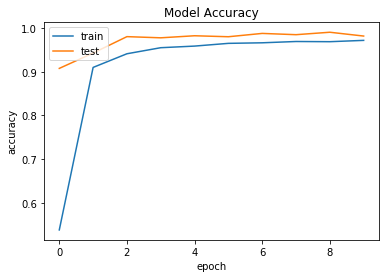

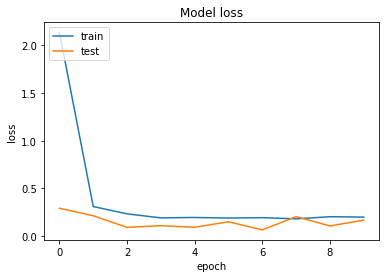

In [81]:
plot_train_history(history_v1)

In [82]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [95]:
#score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

Score:  [0.16708121048317573, 0.9812709]


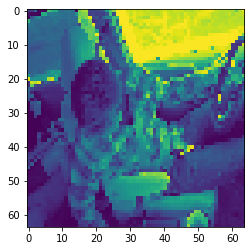

Y prediction: [[3.7026958e-26 1.3175703e-26 1.6434140e-24 1.9086329e-26 1.4704743e-24
  3.1549465e-30 3.7984513e-25 1.0000000e+00 6.6129172e-11 2.9881276e-14]]
Predicted: Reaching behind


In [120]:
img = x_test[1:2]
img = img.astype(np.float32)
image = x_test[1]
image = cv2.resize(image,(img_rows,img_cols))
plt.imshow(image)
plt.show()
y = model_v1.predict(img)
print('Y prediction: {}'.format(y))
print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y)))))